In [1]:
import stuett
from stuett.global_config import get_setting, setting_exists
import argparse
from pathlib import Path
from datetime import datetime, date, timedelta
import plotly.graph_objects as go
import pandas as pd
import xarray as xr

In [2]:
# change here to get data from another sensor
rock_temperature_file_mh30 = "MH30_temperature_rock_2017.csv" # North
rock_temperature_file_mh10 = "MH10_temperature_rock_2017.csv" # South
radiation_file = "MH15_radiometer__conv_2017.csv"

account_name = (
    get_setting("azure")["account_name"]
    if setting_exists("azure")
    else "storageaccountperma8980"
)
account_key = (
    get_setting("azure")["account_key"] if setting_exists("azure") else None
)
store = stuett.ABSStore(
    container="hackathon-on-permafrost",
    prefix="timeseries_derived_data_products",
    account_name=account_name,
    account_key=account_key, 
)

In [3]:
rock_temperature_node_mh30 = stuett.data.CsvSource(rock_temperature_file_mh30,store=store)
rock_temp_mh30 = rock_temperature_node_mh30()

rock_temperature_node_mh10 = stuett.data.CsvSource(rock_temperature_file_mh10,store=store)
rock_temp_mh10 = rock_temperature_node_mh10()

radiation_node = stuett.data.CsvSource(radiation_file,store=store)
radiation = radiation_node()

In [4]:
net_solar_radiation = radiation[:, 4]
net_radiation = radiation[:, 14]

rad_ind = 14

In [5]:
print('MH30')
print([(i, e) for i, e in enumerate(rock_temp_mh30['name'].to_dict()['data'])])
print()
print('MH10')
print([(i, e) for i, e in enumerate(rock_temp_mh10['name'].to_dict()['data'])])
print()
print('Radiation')
print([(i, e) for i, e in enumerate(radiation['name'].to_dict()['data'])])

MH30
[(0, 'position'), (1, 'temperature_5cm'), (2, 'temperature_10cm'), (3, 'temperature_20cm'), (4, 'temperature_30cm'), (5, 'temperature_50cm'), (6, 'temperature_100cm')]

MH10
[(0, 'temperature_nearsurface_t2'), (1, 'device_id'), (2, 'position'), (3, 'ref1'), (4, 'ref2'), (5, 'ref3'), (6, 'ref4'), (7, 'ref5'), (8, 'temperature_10cm'), (9, 'temperature_35cm'), (10, 'temperature_60cm'), (11, 'temperature_85cm')]

Radiation
[(0, 'position'), (1, 'irradiance_shortwave_up'), (2, 'irradiance_shortwave_down'), (3, 'albedo'), (4, 'net_solar_radiation'), (5, 'irradiance_longwave_up_notemp'), (6, 'irradiance_longwave_down_notemp'), (7, 'net_far_infrared_radiation_notemp'), (8, 'temperature'), (9, 'irradiance_longwave_up'), (10, 'irradiance_longwave_down'), (11, 'net_far_infrared_radiation'), (12, 'sky_temperature'), (13, 'ground_temperature'), (14, 'net_radiation')]


In [6]:
rock_temp_mh30['name'].to_dict()['coords']['unit']['data']

['', '°C', '°C', '°C', '°C', '°C', '°C']

In [7]:
rock_temp_mh10['name'].to_dict()['coords']['unit']['data']

['°C', '', '', '°C', '°C', '°C', '°C', '°C', '°C', '°C', '°C', '°C']

In [8]:
radiation['unit'].values

array(['', 'Wm^-2', 'Wm^-2', '', 'Wm^-2', 'Wm^-2', 'Wm^-2', 'Wm^-2', '°C',
       'Wm^-2', 'Wm^-2', 'Wm^-2', '°C', '°C', 'Wm^-2'],
      dtype='<U5')

In [9]:
rock_temp_mh30_day = None
rock_temp_mh10_day = None
radiation_day = None

start_date = date(2017, 1, 1)
end_date = date(2017, 12, 31)
delta = timedelta(days=1)
while start_date < end_date:
    #print (start_date.strftime("%Y-%m-%d"))
    start_date += delta
    d = start_date
    
    chunk = rock_temp_mh30.loc[datetime(d.year, d.month, d.day, 8) : datetime(d.year, d.month, d.day, 17)]
    if rock_temp_mh30_day is None:
        rock_temp_mh30_day = chunk
    else:
        rock_temp_mh30_day = xr.concat([rock_temp_mh30_day, chunk], 'time')
        
    chunk = rock_temp_mh10.loc[datetime(d.year, d.month, d.day, 8) : datetime(d.year, d.month, d.day, 17)]
    if rock_temp_mh10_day is None:
        rock_temp_mh10_day = chunk
    else:
        rock_temp_mh10_day = xr.concat([rock_temp_mh10_day, chunk], 'time')
        
    chunk = radiation.loc[datetime(d.year, d.month, d.day, 8) : datetime(d.year, d.month, d.day, 17)]
    if radiation_day is None:
        radiation_day = chunk
    else:
        radiation_day = xr.concat([radiation_day, chunk], 'time')

In [10]:
rock_temp_mh30_day.shape

(3640, 7)

In [11]:
rock_temp_mh30.shape

(8760, 7)

In [12]:
radiation_day.shape

(3640, 15)

Text(0, 0.5, 'Radiation')

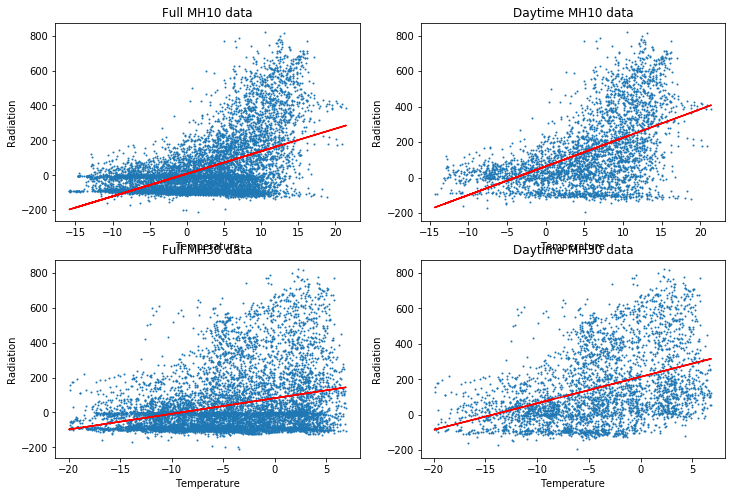

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)

mask = ~np.isnan(rock_temp_mh10[:, 8])
slope, intercept, _, _, _ = linregress(rock_temp_mh10[mask, 8], radiation[mask, rad_ind])

plt.title('Full MH10 data')
plt.scatter(rock_temp_mh10[:, 8], radiation[:, rad_ind], s=1)
plt.plot(rock_temp_mh10[:, 8], intercept + slope*rock_temp_mh10[:, 8], 'r')
plt.xlabel('Temperature')
plt.ylabel('Radiation')

plt.subplot(2, 2, 2)

mask = ~np.isnan(rock_temp_mh10_day[:, 8])
slope, intercept, _, _, _ = linregress(rock_temp_mh10_day[mask, 8], radiation_day[mask, rad_ind])

plt.title('Daytime MH10 data')
plt.scatter(rock_temp_mh10_day[:, 8], radiation_day[:, rad_ind], s=1)
plt.plot(rock_temp_mh10_day[:, 8], intercept + slope*rock_temp_mh10_day[:, 8], 'r')
plt.xlabel('Temperature')
plt.ylabel('Radiation')

plt.subplot(2, 2, 3)

mask = ~np.isnan(rock_temp_mh30[:, 2])
slope, intercept, _, _, _ = linregress(rock_temp_mh30[mask, 2], radiation[mask, rad_ind])

plt.title('Full MH30 data')
plt.scatter(rock_temp_mh30[:, 2], radiation[:, rad_ind], s=1)
plt.plot(rock_temp_mh30[:, 2], intercept + slope*rock_temp_mh30[:, 2], 'r')
plt.xlabel('Temperature')
plt.ylabel('Radiation')

plt.subplot(2, 2, 4)

mask = ~np.isnan(rock_temp_mh30_day[:, 2])
slope, intercept, _, _, _ = linregress(rock_temp_mh30_day[mask, 2], radiation_day[mask, rad_ind])

plt.title('Daytime MH30 data')
plt.scatter(rock_temp_mh30_day[:, 2], radiation_day[:, rad_ind], s=1)
plt.plot(rock_temp_mh30_day[:, 2], intercept + slope*rock_temp_mh30_day[:, 2], 'r')
plt.xlabel('Temperature')
plt.ylabel('Radiation')

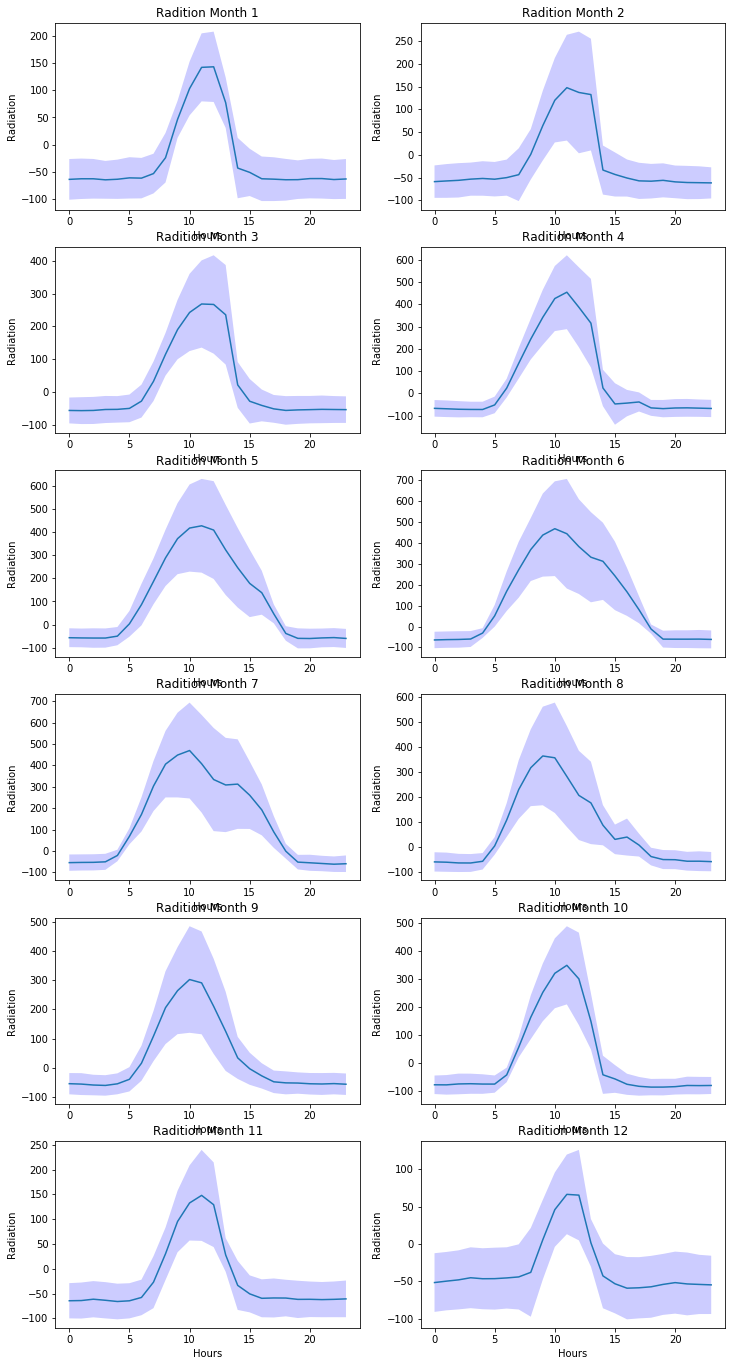

In [14]:
from calendar import monthrange

plt.figure(figsize=(12,24))

for i in range(12):
    m = i+1
    ndays = monthrange(2017, m)[1]
    
    plt.subplot(6, 2, m)
    
    plt.title('Radition Month %d' % m)
    
    data = np.empty((ndays, 24))
    
    for d in range(1, ndays+1):
        data[d-1, :] = radiation.loc[datetime(2017, m, d, 0) : datetime(2017, m, d, 23)][:, rad_ind]
    
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    
    plt.plot(mean)
    plt.gca().fill_between(np.arange(24), mean+std, mean-std, facecolor='blue', alpha=0.2)
    
    
    plt.xlabel('Hours')
    plt.ylabel('Radiation')

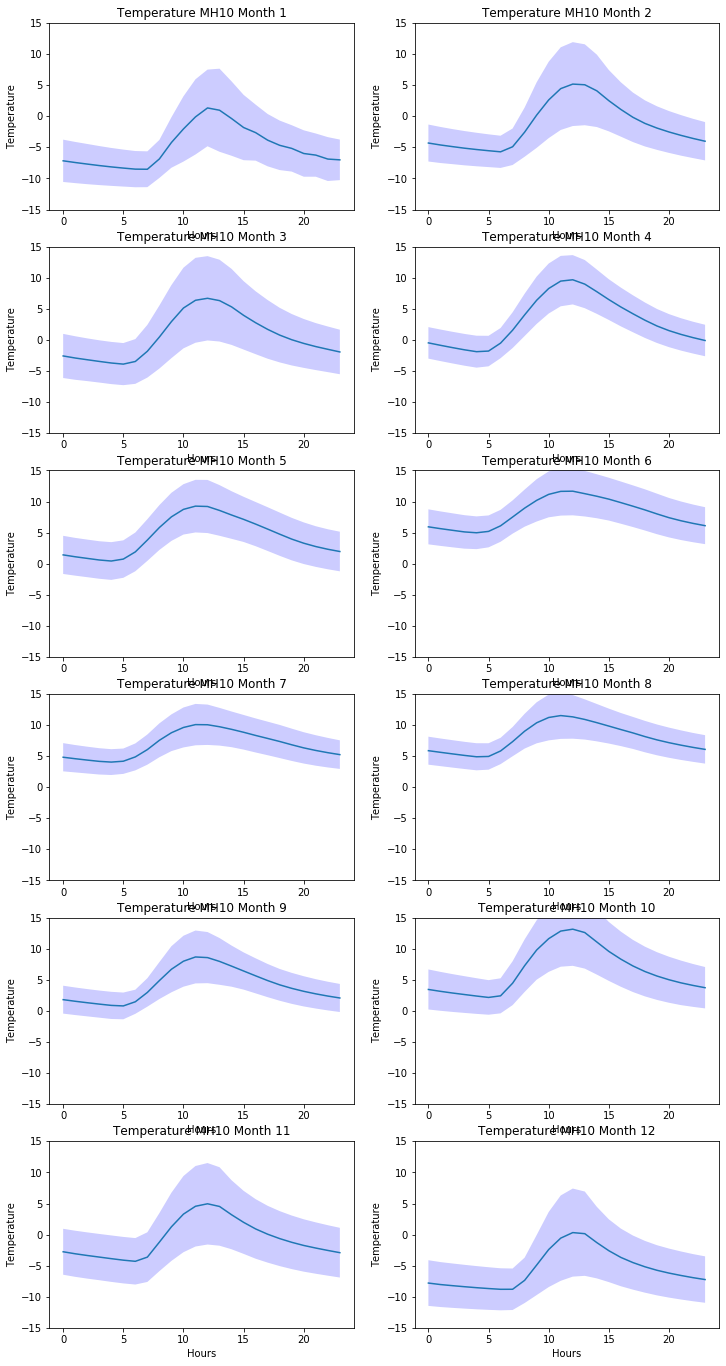

In [15]:
plt.figure(figsize=(12,24))

for i in range(12):
    m = i+1
    ndays = monthrange(2017, m)[1]
    
    plt.subplot(6, 2, m)
    
    plt.title('Temperature MH10 Month %d' % m)
    
    data = np.empty((ndays, 24))
    
    for d in range(1, ndays+1):
        data[d-1, :] = rock_temp_mh10.loc[datetime(2017, m, d, 0) : datetime(2017, m, d, 23)][:, 8]
    
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    
    plt.plot(mean)
    plt.gca().fill_between(np.arange(24), mean+std, mean-std, facecolor='blue', alpha=0.2)
    
    
    plt.xlabel('Hours')
    plt.ylabel('Temperature')
    
    plt.ylim(-15,15)

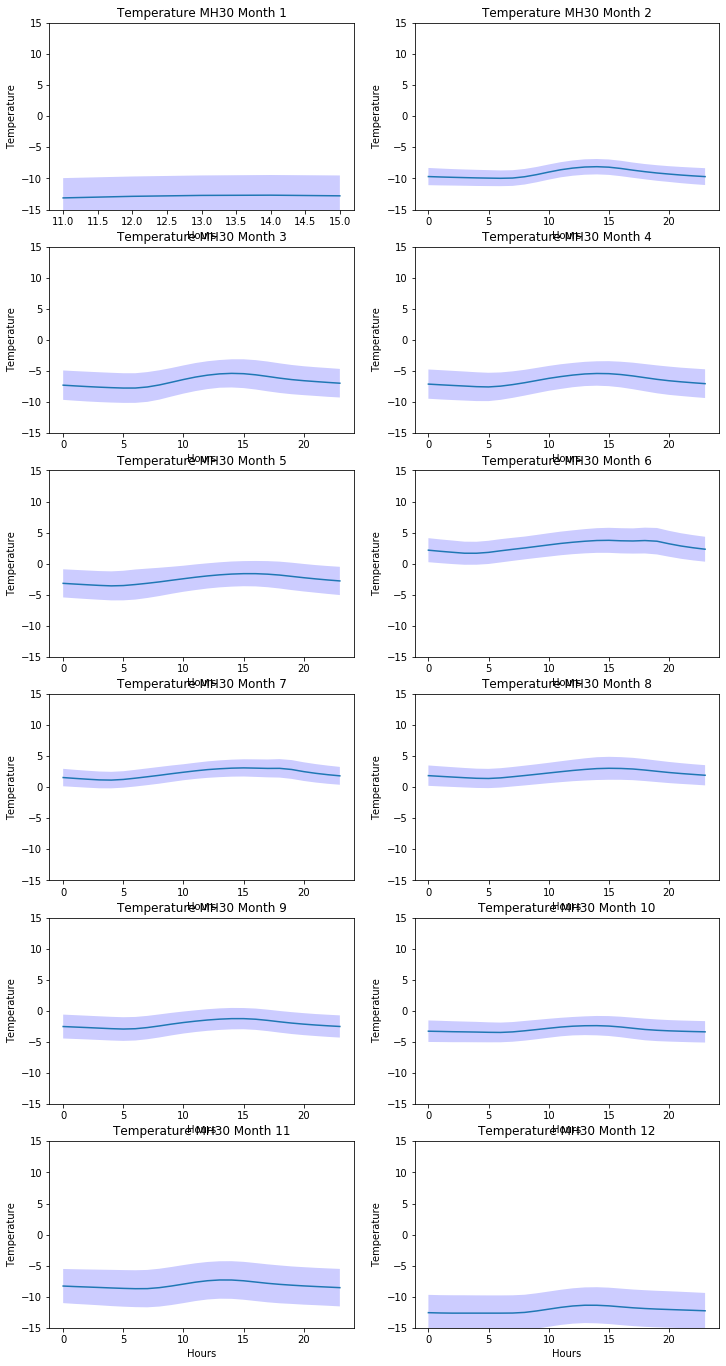

In [16]:
plt.figure(figsize=(12,24))

for i in range(12):
    m = i+1
    ndays = monthrange(2017, m)[1]
    
    plt.subplot(6, 2, m)
    
    plt.title('Temperature MH30 Month %d' % m)
    
    data = np.empty((ndays, 24))
    
    for d in range(1, ndays+1):
        data[d-1, :] = rock_temp_mh30.loc[datetime(2017, m, d, 0) : datetime(2017, m, d, 23)][:, 2]
    
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    
    plt.plot(mean)
    plt.gca().fill_between(np.arange(24), mean+std, mean-std, facecolor='blue', alpha=0.2)
    
    
    plt.xlabel('Hours')
    plt.ylabel('Temperature')
    
    plt.ylim(-15,15)

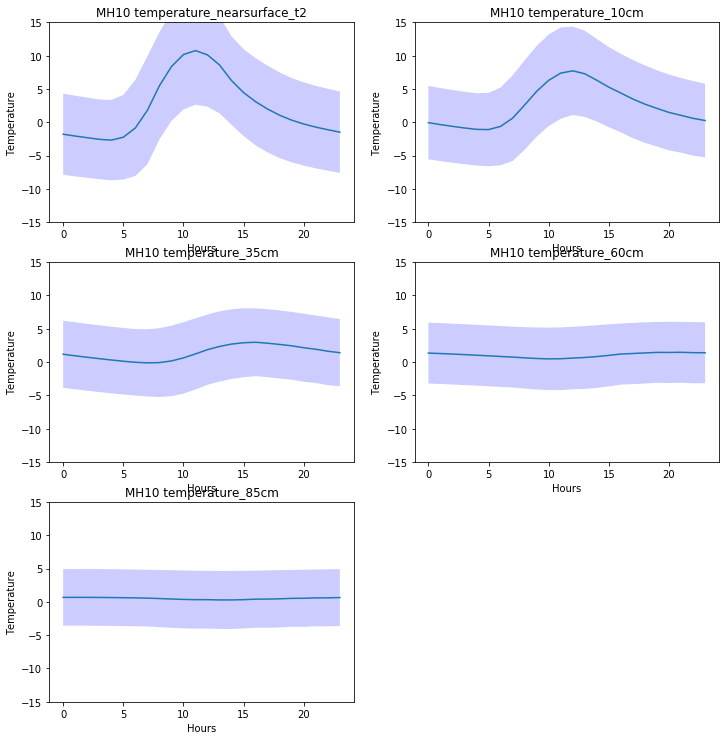

In [17]:
depths = []

for i, e in enumerate(rock_temp_mh10['name'].to_dict()['data']):
    if e.startswith('temp'):
        depths.append([i, e])

plt.figure(figsize=(12, 2.5 * len(depths)))

ndays = np.sum([monthrange(2017, m)[1] for m in range(1, 13)])
        
for i in range(len(depths)):
    ind, name = depths[i]
    
    plt.subplot(np.ceil(len(depths)/2), 2, i+1)
    
    plt.title('MH10 %s' % name)
    
    data = np.empty((ndays, 24))
    
    j = 0
    for m in range(1, 13):
        for d in range(1, monthrange(2017, m)[1]+1):
            data[j, :] = rock_temp_mh10.loc[datetime(2017, m, d, 0) : datetime(2017, m, d, 23)][:, ind]
            j += 1
    
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    
    plt.plot(mean)
    plt.gca().fill_between(np.arange(24), mean+std, mean-std, facecolor='blue', alpha=0.2)
    
    
    plt.xlabel('Hours')
    plt.ylabel('Temperature')
    
    plt.ylim(-15,15)

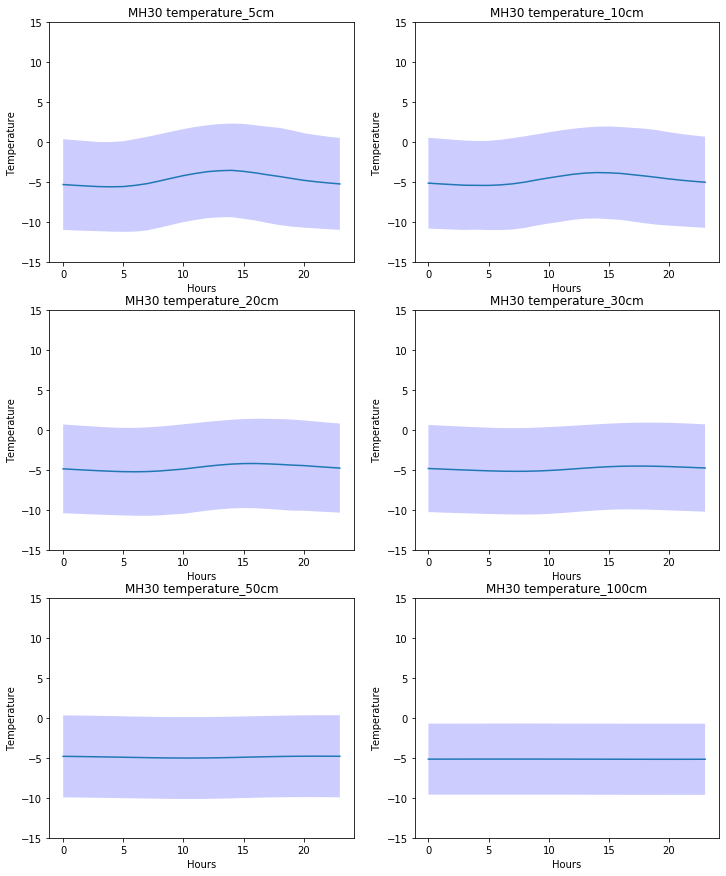

In [18]:
depths = []

for i, e in enumerate(rock_temp_mh30['name'].to_dict()['data']):
    if e.startswith('temp'):
        depths.append([i, e])

plt.figure(figsize=(12, 2.5 * len(depths)))

ndays = np.sum([monthrange(2017, m)[1] for m in range(1, 13)])
        
for i in range(len(depths)):
    ind, name = depths[i]
    
    plt.subplot(np.ceil(len(depths)/2), 2, i+1)
    
    plt.title('MH30 %s' % name)
    
    data = np.empty((ndays, 24))
    
    j = 0
    for m in range(1, 13):
        for d in range(1, monthrange(2017, m)[1]+1):
            data[j, :] = rock_temp_mh30.loc[datetime(2017, m, d, 0) : datetime(2017, m, d, 23)][:, ind]
            j += 1
    
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    
    plt.plot(mean)
    plt.gca().fill_between(np.arange(24), mean+std, mean-std, facecolor='blue', alpha=0.2)
    
    
    plt.xlabel('Hours')
    plt.ylabel('Temperature')
    
    plt.ylim(-15,15)

<xarray.DataArray 'CSV' ()>
array(102.66939323059361)
Coordinates:
    name     <U33 'net_solar_radiation'
    unit     <U5 'Wm^-2'

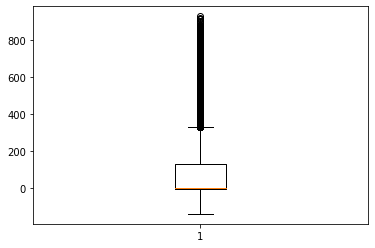

In [19]:
plt.figure()
plt.boxplot(radiation[:, 4])

radiation[:, 4].mean()

# Images

In [20]:
store = stuett.ABSStore(
    container="hackathon-on-permafrost",
    prefix="timelapse_images_fast",
    account_name=account_name,
    account_key=account_key, 
)

In [21]:
image_node = stuett.data.MHDSLRFilenames(
    store=store,
    force_write_to_remote=True,
    as_pandas=False,
)

In [22]:
images = image_node({"start_time": "2017-01-01", "end_time": "2017-12-31"})

In [23]:
images.shape

(1, 102338)

In [24]:
images

<xarray.DataArray (variable: 1, time: 102338)>
array([['2017-01-01/20170101_070009.JPG', '2017-01-01/20170101_070409.JPG',
        '2017-01-01/20170101_070809.JPG', ...,
        '2017-12-30/20171230_234808.JPG', '2017-12-30/20171230_235207.JPG',
        '2017-12-30/20171230_235608.JPG']], dtype=object)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-01T07:00:09 ... 2017-12-30T23:56:08
  * variable  (variable) <U8 'filename'

In [25]:
str(images[0, 0].values)

'2017-01-01/20170101_070009.JPG'

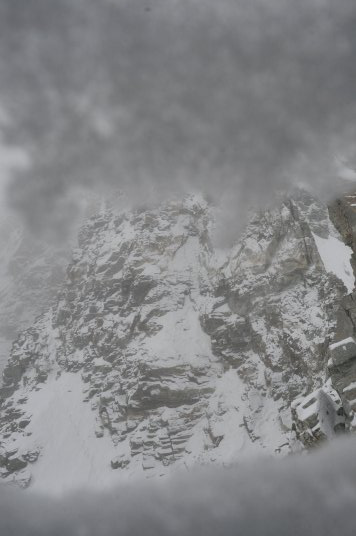

In [26]:
from PIL import Image
import io

img_key = str(images[0, 2000].values)

img = Image.open(io.BytesIO(store[img_key]))
img = img.rotate(90, expand=1)
data = np.array(img.convert('RGB')).transpose([2,0,1])
data = data.astype(np.float32)

img

In [27]:
images['time']

<xarray.DataArray 'time' (time: 102338)>
array(['2017-01-01T07:00:09.000000000', '2017-01-01T07:04:09.000000000',
       '2017-01-01T07:08:09.000000000', ..., '2017-12-30T23:48:08.000000000',
       '2017-12-30T23:52:07.000000000', '2017-12-30T23:56:08.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T07:00:09 ... 2017-12-30T23:56:08

### NOTE the camera is sometimes shut off (especially during the night)

In [28]:
images['time'][0]

<xarray.DataArray 'time' ()>
array(1483254009000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01T07:00:09

In [29]:
rock_temp_mh10['time'][0]

<xarray.DataArray 'time' ()>
array(1483228800000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01

In [30]:
8760 / 365

24.0

In [31]:
102338 / 365 / 24

11.682420091324202

In [32]:
(images['time'][0] - rock_temp_mh10['time'][0]).values.astype('timedelta64[m]')

numpy.timedelta64(420,'m')

/home/christian/anaconda3/envs/permafrost/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



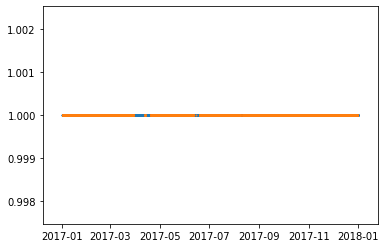

In [33]:
plt.figure()
plt.scatter(np.array(rock_temp_mh10['time'].values), np.ones_like(rock_temp_mh10['time'], dtype=np.float64), s=1)
plt.scatter(np.array(images['time'].values), np.ones_like(images['time'], dtype=np.float64), s=1)

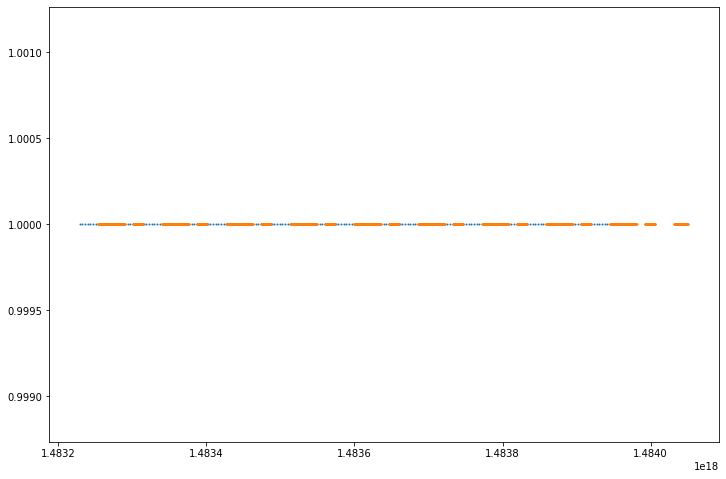

In [34]:
plt.figure(figsize=(12,8))

temp_vals = np.array(rock_temp_mh10['time'].values[:200], dtype=np.float64)
img_vals = np.array(images['time'].values[:2000], dtype=np.float64)

plt.scatter(temp_vals, np.ones_like(temp_vals), s=1)
plt.scatter(img_vals, np.ones_like(img_vals), s=1)

### Extract temperature values for which an image is close-by

In [35]:
j = 0
n = len(images['time'])

pairs = []

for i, t in enumerate(rock_temp_mh10['time'].values):
    while j < n:
        if (images['time'][j] - t).values.astype('timedelta64[m]').astype(np.int) > 10:
            # Image too far in the future, ignore sensor value.
            break
           
        absdiff = np.abs((images['time'][j] - t).values.astype('timedelta64[m]').astype(np.int))
        if absdiff < 10:
            # The image is very close, simply check whether the next picture is even closer.
            if j+1 < n:
                absdiff2 = np.abs((images['time'][j+1] - t).values.astype('timedelta64[m]').astype(np.int))
            else:
                absdiff2 = None
                
            if absdiff2 is None or absdiff < absdiff2:
                pairs.append((i, j))
                j += 1
            else:
                pairs.append((i, j+1))
                j += 2
            break
        
        j += 1
        

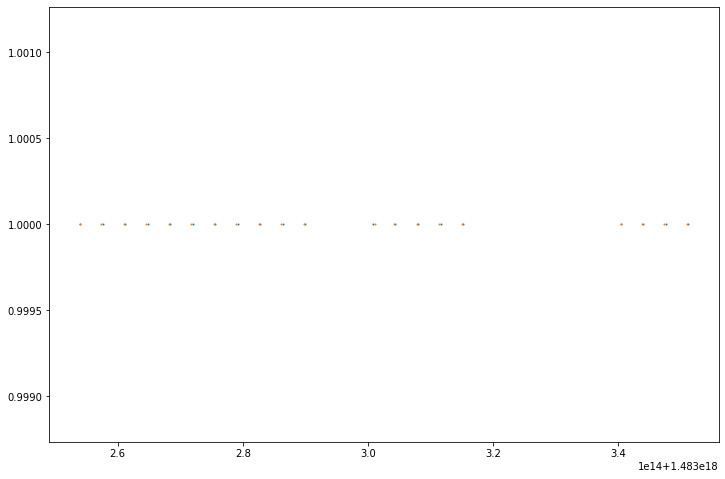

In [36]:
plt.figure(figsize=(12,8))

temp_vals = np.array([rock_temp_mh10['time'].values[i] for i, _ in pairs], dtype=np.float64)[:20]
img_vals = np.array([images['time'].values[j] for _, j in pairs], dtype=np.float64)[:20]

plt.scatter(temp_vals, np.ones_like(temp_vals), s=1)
plt.scatter(img_vals, np.ones_like(img_vals), s=1)

In [39]:
for t1, t2 in zip(radiation['time'], rock_temp_mh10['time']):
    assert(t1 == t2)